<a href="https://colab.research.google.com/github/wow7seven/Adversarial-Attacks/blob/main/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import PIL
import os

from torch import optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import save_image
from sklearn.manifold import TSNE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Question 1

## Part 1

### Dataset

In [ ]:
batch_size = 500

# CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                train=True,
                                                transform=transforms.ToTensor(),
                                                download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

num_classes = 10

Files already downloaded and verified


In [ ]:
for images,_  in train_loader:
  i = images
  break

i.shape

torch.Size([500, 3, 32, 32])

### CNN model

In [ ]:
class CNN_class(nn.Module):

  def __init__(self):
    super(CNN_class, self).__init__()
    self.conv1 = nn.Conv2d( in_channels = 3, out_channels = 8 ,kernel_size = 3)
    self.conv2 = nn.Conv2d( in_channels = 8, out_channels = 12 ,kernel_size = 3)
    self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 15 ,kernel_size = 3)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(2535, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

model = CNN_class().to(device)
model

CNN_class(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 15, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2535, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

### Accuracy function

In [ ]:
def accuracy(y_pred, y_test):
  count = 0
  val = []
  for i in range(len(y_test)):
    val.append(torch.argmax(y_pred[i]))
    if val[i] == y_test[i]:
      count += 1
  acc = count/len(y_test)
  return 100*acc

### Checker Function
#### (For training)

In [ ]:
def checker(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)

  num_epochs = 10
  overall_train_error = []
  overall_train_acc = []

  overall_val_error = []
  overall_val_acc = []

  for epoch in range(num_epochs):
    print('EPOCH :', epoch+1)
    epoch_loss = 0
    epoch_acc = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += accuracy(output,labels)

    overall_train_acc.append(epoch_acc/len(train_loader))
    overall_train_error.append(epoch_loss/len(train_loader))
    print("Training loss =", epoch_loss/len(train_loader))
    print("Training accuracy =", epoch_acc/len(train_loader))
    print()

  return overall_train_error, overall_train_acc


In [ ]:
before_attack_train_error, before_attack_train_acc = checker(model)

EPOCH : 1
Training loss = 1.8008596909046173
Training accuracy = 34.83599999999999

EPOCH : 2
Training loss = 1.432233909368515
Training accuracy = 48.495999999999995

EPOCH : 3
Training loss = 1.2747790217399597
Training accuracy = 54.727999999999994

EPOCH : 4
Training loss = 1.1456941616535188
Training accuracy = 59.39

EPOCH : 5
Training loss = 1.0292216217517853
Training accuracy = 63.557999999999986

EPOCH : 6
Training loss = 0.9361832737922668
Training accuracy = 67.074

EPOCH : 7
Training loss = 0.854863743185997
Training accuracy = 69.96200000000003

EPOCH : 8
Training loss = 0.7743500757217407
Training accuracy = 72.94999999999997

EPOCH : 9
Training loss = 0.69099629342556
Training accuracy = 76.14200000000001

EPOCH : 10
Training loss = 0.6156964382529259
Training accuracy = 78.72999999999999



In [ ]:
def final(model):
  epoch_acc = 0
  epoch_loss = 0
  criterion = nn.CrossEntropyLoss()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    epoch_loss += loss.item()
    epoch_acc += accuracy(output,labels)

  print("Testing loss =", epoch_loss/len(test_loader))
  print("Testing accuracy =", epoch_acc/len(test_loader))
  print()

  return epoch_loss/len(test_loader),epoch_acc/len(test_loader)

In [ ]:
before_attack_test_error, before_attack_test_acc = final(model)

Testing loss = 1.08484907746315
Testing accuracy = 64.76



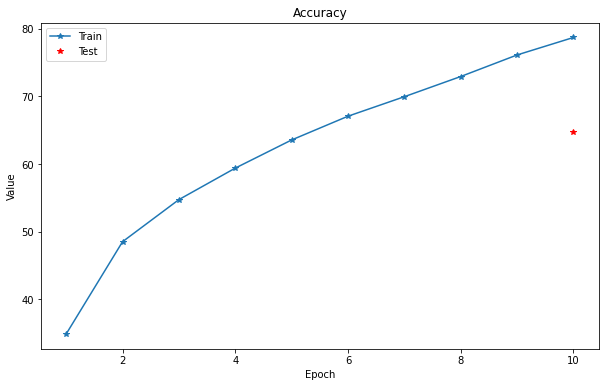

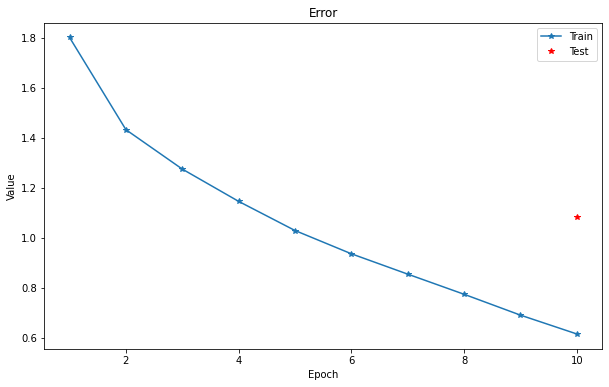

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(range(1,11), before_attack_train_acc, '*-')
plt.plot(10, before_attack_test_acc, 'r*')
plt.annotate('Test accuracy = {:.2f} %'.format(before_attack_test_acc), xy=(12, before_attack_test_acc - 5), xytext=(12, before_attack_test_acc - 3), color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Test'])
plt.title('Accuracy')
plt.show()

print()

plt.figure(figsize = (10,6))
plt.plot(range(1,11), before_attack_train_error, '*-')
plt.plot(10, before_attack_test_error, 'r*')
plt.annotate('Test error = {:.2f}'.format(before_attack_test_error), xy=(13.25, before_attack_test_error - .1), xytext=(13.25, before_attack_test_error - .1), color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Test'])
plt.title('Error')
plt.show()


### FGSM

In [ ]:
def fgsm(image, epsilon, data_grad):

    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad                      # image + change each pixel by a little
    perturbed_image = torch.clamp(perturbed_image, 0, 1)                    # to confine the range to [0,1]

    return perturbed_image


### Attacking the model function

In [ ]:
def attack(model, epsilon, device):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    model.eval()

    acc = 0

    # Iterate over the test set
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        images.requires_grad = True                                             # This is done to get data.grad(here images.grad) for generating pertubated images using fgsm function
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        perturbed_images = fgsm(images, epsilon, images.grad)

        outputs_after_attack = model(perturbed_images)
        acc += accuracy(outputs_after_attack,labels)

    acc = acc/len(test_loader)
    return acc


### Varing epsilons

In [ ]:
epsilons = np.arange(0,0.21,.025)
accuracies = []
examples = []

In [ ]:
for eps in epsilons:
    acc = attack(model, eps, device)
    accuracies.append(acc)

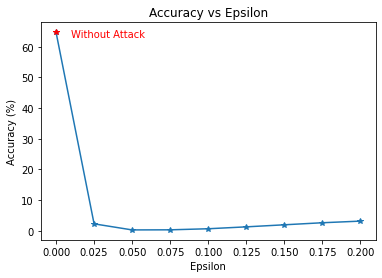

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 101, step=10))
plt.xticks(np.arange(0, .35, step=.025))
plt.plot(0 , accuracies[0], 'r*')
plt.annotate('Without Attack', xy=(0.01, accuracies[0] - 1.5), xytext=(0.01, accuracies[0] - 1.5), color = 'red')
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.show()


In [ ]:
accuracies

[64.76,
 2.2500000000000004,
 0.27,
 0.30000000000000004,
 0.65,
 1.27,
 1.9400000000000002,
 2.6100000000000003,
 3.14]

### Using the best epsilon

In [ ]:
def best_attack(model, epsilon, device):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    model.eval()

    examples = []
    acc = 0
    i = 0
    # Iterate over the test set
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        images.requires_grad = True                                             # This is done to get data.grad(here images.grad) for generating pertubated images using fgsm function
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        perturbed_images = fgsm(images, epsilon, images.grad)

        outputs_after_attack = model(perturbed_images)
        acc += accuracy(outputs_after_attack,labels)

        _, preds = torch.max(outputs_after_attack.data, 1)
    return images, perturbed_images, labels, preds


In [ ]:
images, perturbed_images, labels, preds_after_attack = best_attack(model, .05, device)

### Visualizing

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
images = images[:5]
perturbed_images = perturbed_images[:5]
labels = labels[:5]
preds_after_attack = preds_after_attack[:5]

In [ ]:
(preds_after_attack)

tensor([5, 4, 4, 4, 4], device='cuda:0')

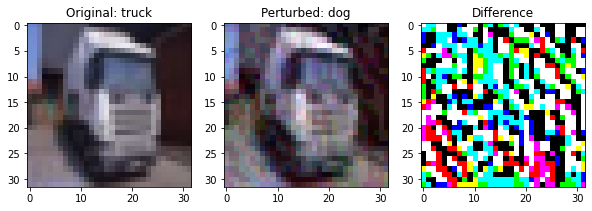

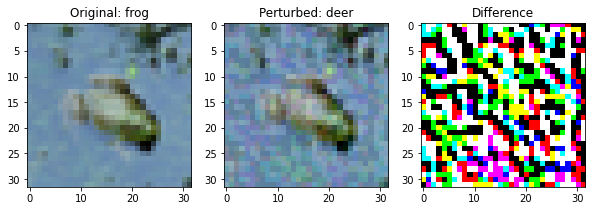

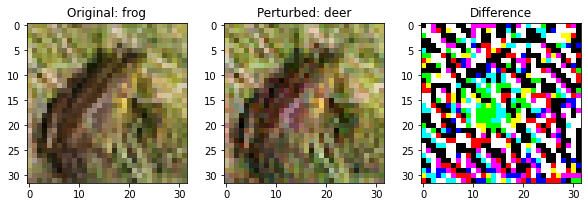

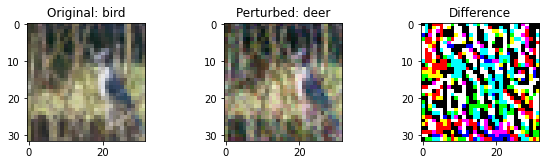

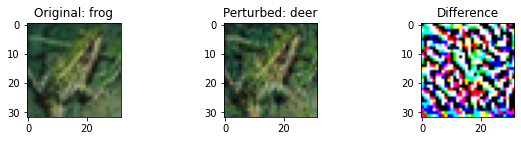

In [ ]:
for i in range(5):
  plt.figure(figsize=(10,10))

  plt.subplot(i+1,3,1)
  plt.title("Original: " +  str(classes[labels[i]]))
  plt.imshow(images[i].cpu().detach().numpy().transpose(1,2,0).clip(0,255))

  plt.subplot(i+1,3,2)
  plt.title("Perturbed: " + str(classes[preds_after_attack[i]]))
  plt.imshow(perturbed_images[i].cpu().detach().numpy().transpose(1,2,0).clip(0,255))

  plt.subplot(i+1,3,3)
  plt.title("Difference")
  plt.imshow(((images[i] - perturbed_images[i])*255/0.5).cpu().detach().numpy().transpose(1,2,0).clip(0,1))

  plt.show()
  print()

## Part 2

### Dataset - SVHN

In [ ]:
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

### Defining the two models

In [ ]:
ResNet = torchvision.models.resnet18(weights = 'DEFAULT')
ResNet.fc = nn.Linear(in_features=512, out_features=10, bias=True)              # Since SVHN has 10 classes
ResNet = ResNet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
ShuffleNetV2 = torchvision.models.shufflenet_v2_x1_0(weights = 'DEFAULT')
ShuffleNetV2.fc = nn.Linear(in_features=1024, out_features=10, bias=True)              # Since SVHN has 10 classes
ShuffleNetV2 = ShuffleNetV2.to(device)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

### Train ResNet and ShuffleNet on SVHN

In [ ]:
def start(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)

  num_epochs = 10

  overall_train_error = []
  overall_train_acc = []

  for epoch in range(num_epochs):
    print('EPOCH :', epoch+1)
    epoch_loss = 0
    epoch_acc = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += accuracy(output,labels)

    overall_train_acc.append(epoch_acc/len(train_loader))
    overall_train_error.append(epoch_loss/len(train_loader))
    print("Training loss =", epoch_loss/len(train_loader))
    print("Training accuracy =", epoch_acc/len(train_loader))
    print()

  return overall_train_error, overall_train_acc


In [ ]:
def end(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)

  epoch_loss = 0
  epoch_acc = 0

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model(images)
    loss = criterion(output, labels)

    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += accuracy(output,labels)

  print("Testing loss =", epoch_loss/len(test_loader))
  print("Testing accuracy =", epoch_acc/len(test_loader))
  print()

  return epoch_loss/len(test_loader), epoch_acc/len(test_loader)


In [ ]:
resnet_train_error, resnet_train_acc = start(ResNet)

EPOCH : 1
Training loss = 1.0121779572963714
Training accuracy = 65.168

EPOCH : 2
Training loss = 0.6261012586951256
Training accuracy = 78.64999999999998

EPOCH : 3
Training loss = 0.4920819002389908
Training accuracy = 83.37799999999999

EPOCH : 4
Training loss = 0.4066070318222046
Training accuracy = 86.134

EPOCH : 5
Training loss = 0.31416602939367294
Training accuracy = 89.30000000000001

EPOCH : 6
Training loss = 0.24916526153683663
Training accuracy = 91.59400000000001

EPOCH : 7
Training loss = 0.18979171082377433
Training accuracy = 93.49199999999998

EPOCH : 8
Training loss = 0.16171503134071827
Training accuracy = 94.40400000000004

EPOCH : 9
Training loss = 0.12460955135524272
Training accuracy = 95.834

EPOCH : 10
Training loss = 0.40936159159988167
Training accuracy = 86.53800000000001



In [ ]:
resnet_test_error, resnet_test_acc = end(ResNet)

Testing loss = 0.6729918092489242
Testing accuracy = 77.93



In [ ]:
shufflenet_train_error, shufflenet_train_acc = start(ShuffleNetV2)

EPOCH : 1
Training loss = 1.0874761956930161
Training accuracy = 63.43200000000001

EPOCH : 2
Training loss = 0.6746922367811203
Training accuracy = 76.60999999999997

EPOCH : 3
Training loss = 0.5583290240168571
Training accuracy = 80.59000000000002

EPOCH : 4
Training loss = 0.4744144469499588
Training accuracy = 83.40999999999997

EPOCH : 5
Training loss = 0.4129881769418716
Training accuracy = 85.656

EPOCH : 6
Training loss = 0.37287394374608995
Training accuracy = 86.89600000000002

EPOCH : 7
Training loss = 0.3250474524497986
Training accuracy = 88.54599999999999

EPOCH : 8
Training loss = 0.28727555930614473
Training accuracy = 89.786

EPOCH : 9
Training loss = 0.25451974138617517
Training accuracy = 91.05000000000004

EPOCH : 10
Training loss = 0.23184869572520256
Training accuracy = 91.80000000000001



In [ ]:
shufflenet_test_error, shufflenet_test_acc = end(ShuffleNetV2)

Testing loss = 0.7231867045164109
Testing accuracy = 75.84



### Defininng two attacks

### Pgd Attack

In [ ]:
# def fgsm(image, epsilon, data_grad):

#     sign_data_grad = data_grad.sign()
#     perturbed_image = image + epsilon * sign_data_grad                      # image + change each pixel by a little
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)                    # to confine the range to [0,1]

#     return perturbed_image

def pgd(model, images, labels, epsilon, alpha, num_iter, device, grad_chupa):
  criterion = nn.CrossEntropyLoss()
  for i in range(num_iter):
    sign_grad_chupa = images.grad.data.sign()
    purturbed_image = (images + alpha*sign_grad_chupa).clamp(0, 1)
    purturbed_image.requires_grad = True
    output = model(purturbed_image)
    loss = criterion(output, labels)
    loss.backward()
    data_grad = purturbed_image.grad.data
    purturbed_image.requires_grad = False
    image = purturbed_image
  return purturbed_image


In [ ]:
from torch.autograd import grad
# import tqdm as tqdm
def pgd_attack(model, epsilon, alpha, num_iter):
  criterion = nn.CrossEntropyLoss()
  model.eval()

  acc = 0

  for images, labels in (testloader):
      images, labels = images.to(device), labels.to(device)
      images.requires_grad = True
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      images.requires_grad = False
      grad_chupa = images.grad.data
      # Generate the perturbed images using FGSM attack
      perturbed_images = pgd(model, images, labels, epsilon, alpha, num_iter, device, grad_chupa)

      outputs_after_attack = model(perturbed_images)
      acc += accuracy(outputs_after_attack,labels)


  # Calculate the accuracy and return the result
  acc =  acc / len(testloader)
  return acc

In [ ]:
# epsilons = np.arange(0,0.06,.01)
alpha = np.arange(0.01, 0.051, 0.01)
accuracies = []
accuracies_S = []

In [ ]:
for a in alpha:
  acc = pgd_attack(ResNet, 0.05, a, 4)
  accuracies.append(acc)
  print(acc)

1.2830362630608483
0.7260295021511985
1.3560233558696988
2.308696988322065
3.0577750460971114


In [ ]:
for a in alpha:
  acc = pgd_attack(ShuffleNetV2, 0.05, a, 4)
  accuracies_S.append(acc)
  print(acc)

0.18822987092808852
0.3111555009219422
0.9065765212046711
1.8093116164720344
2.7120467117393976


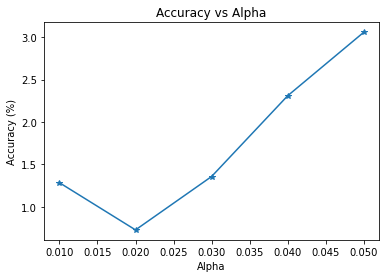

In [ ]:
plt.plot(alpha,accuracies,'*-')
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.show()

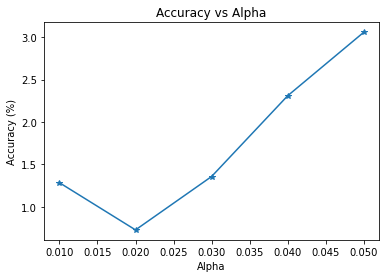

In [ ]:
plt.plot(alpha,accuracies,'*-')
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.show()

### Mask Attack

In [ ]:
def create_mask(image):
    mask_size=12
    x1, y1 = 10, 10
    x2, y2 = x1 + mask_size, y1 + mask_size

    mask = torch.zeros(image.shape)
    mask[:, :, x1:x2, y1:y2] = 1
    return mask

for sample, label in testloader:
    mask = create_mask(sample)
    break

mask = mask.to(device)

In [ ]:
def masking(image, label, mask, epsilon, data_grad, alpha, iters, model):
  criterion = nn.CrossEntropyLoss()
  for i in range(iters):
      if i==iters-1:
          sign_data_grad = (data_grad.sign()*mask)[:,:,10:10+12,10:10+12]
          image[:,:,10:10+12,10:10+12] = 0.5*sign_data_grad
          perturbed_image = image.clamp(0, 1)
      else:
          sign_data_grad = data_grad.sign()*mask
          perturbed_image = (image + alpha*sign_data_grad).clamp(0, 1)
          perturbed_image.requires_grad = True
          output = model(perturbed_image)
          loss = criterion(output, label)
          loss.backward()
          data_grad = perturbed_image.grad.data
          perturbed_image.requires_grad = False
          image = perturbed_image

  return perturbed_image

In [ ]:
def mask_attack(model, epsilon, mask, alpha, num_iter):
  criterion = nn.CrossEntropyLoss()
  model.eval()

  acc = 0

  for images, labels in (testloader):
      images, labels = images.to(device), labels.to(device)
      images.requires_grad = True
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      images.requires_grad = False
      grad = images.grad.data
      # Generate the perturbed images using FGSM attack
      perturbed_images = masking(images, labels, mask, epsilon, grad, alpha, num_iter, model)

      outputs_after_attack = model(perturbed_images)
      acc += accuracy(outputs_after_attack,labels)


  # Calculate the accuracy and return the result
  acc =  acc / len(testloader)
  return acc

In [ ]:
# epsilons = np.arange(0,0.06,.01)
alpha = np.arange(0.01, 0.051, 0.01)
accuracies = []
accuracies_S = []

In [ ]:
for a in alpha:
  acc = mask_attack(ResNet, 0.05, mask, a, 4)
  accuracies.append(acc)
  print(acc)

9.396127842655194
9.653503380454826
9.872464658881377
9.883988936693301
9.47679778733866


In [ ]:
for a in alpha:
  acc = mask_attack(ShuffleNetV2, 0.05, mask, a, 4)
  accuracies_S.append(acc)
  print(acc)

9.499846342962508
9.891671788567917
9.853257529194837
9.926244622003688
9.872464658881377


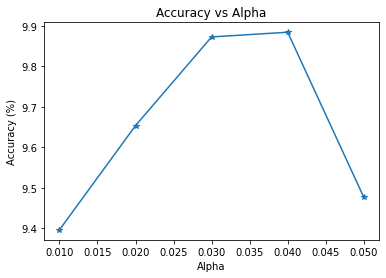

In [ ]:
plt.plot(alpha,accuracies,'*-')
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.show()

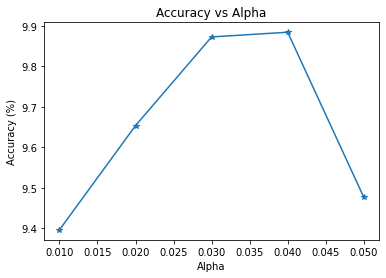

In [ ]:
plt.plot(alpha,accuracies,'*-')
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.show()

## Part 3

In [ ]:
class detection(nn.Module):

  def __init__(self):
    super(detection, self).__init__()
    self.conv1 = nn.Conv2d( in_channels = 3, out_channels = 5 ,kernel_size = 3)
    self.conv2 = nn.Conv2d( in_channels = 5, out_channels = 7 ,kernel_size = 3)
    self.conv3 = nn.Conv2d(in_channels = 7, out_channels = 10 ,kernel_size = 3)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(1690, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.softmax(x, dim=1)
    return output

detect = detection().to(device)
detect

detection(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(7, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1690, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
def detection_checker(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)

  num_epochs = 10
  overall_train_error = []
  overall_train_acc = []

  overall_val_error = []
  overall_val_acc = []

  for epoch in range(num_epochs):
    print('EPOCH :', epoch+1)
    epoch_loss = 0
    epoch_acc = 0

    for images, _ in train_loader:
      images = images.to(device)
      labels = torch.ones(500).type(torch.LongTensor)
      labels = labels.to(device)

      optimizer.zero_grad()


      images.requires_grad = True                                             # This is done to get data.grad(here images.grad) for generating pertubated images using fgsm function
      outputs = model(images)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += accuracy(outputs,labels)

      perturbed_images = fgsm(images, 0.05, images.grad)
      outputs_after_attack = model(perturbed_images)

      labels_attacked = torch.zeros(500).type(torch.LongTensor)
      labels_attacked = labels_attacked.to(device)
      loss = criterion(outputs_after_attack, labels_attacked)
      model.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += accuracy(outputs,labels)



    overall_train_acc.append(epoch_acc/(2*len(train_loader)))
    overall_train_error.append(epoch_loss/(2*len(train_loader)))
    print("Training loss =", epoch_loss/(2*len(train_loader)))
    print("Training accuracy =", epoch_acc/(2*len(train_loader)))
    print()

  return overall_train_error, overall_train_acc


In [ ]:
detection_train_error, detection_train_acc = detection_checker(detect)

EPOCH : 1
Training loss = 0.601921526491642
Training accuracy = 94.83799999999995

EPOCH : 2
Training loss = 0.43760463044047354
Training accuracy = 99.96999999999994

EPOCH : 3
Training loss = 0.39010343357920646
Training accuracy = 99.98599999999999

EPOCH : 4
Training loss = 0.36366113170981407
Training accuracy = 99.992

EPOCH : 5
Training loss = 0.3484829519689083
Training accuracy = 99.99599999999998

EPOCH : 6
Training loss = 0.3391911269724369
Training accuracy = 99.994

EPOCH : 7
Training loss = 0.33308213233947753
Training accuracy = 99.99799999999999

EPOCH : 8
Training loss = 0.32894675686955455
Training accuracy = 99.99199999999999

EPOCH : 9
Training loss = 0.32582056686282157
Training accuracy = 100.0

EPOCH : 10
Training loss = 0.3235594627261162
Training accuracy = 100.0



In [ ]:
def detection_final(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)

  num_epochs = 10
  overall_train_error = []
  overall_train_acc = []

  overall_val_error = []
  overall_val_acc = []

  epoch_loss = 0
  epoch_acc = 0

  for images, _ in test_loader:
    images = images.to(device)
    labels = torch.ones(500).type(torch.LongTensor)
    labels = labels.to(device)

    optimizer.zero_grad()


    images.requires_grad = True                                             # This is done to get data.grad(here images.grad) for generating pertubated images using fgsm function
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    epoch_loss += loss.item()
    epoch_acc += accuracy(outputs,labels)

    perturbed_images = fgsm(images, 0.05, images.grad)
    outputs_after_attack = model(perturbed_images)

    labels_attacked = torch.zeros(500).type(torch.LongTensor)
    labels_attacked = labels_attacked.to(device)
    loss = criterion(outputs_after_attack, labels_attacked)

    epoch_loss += loss.item()
    epoch_acc += accuracy(outputs,labels)

  print("Testing loss =", epoch_loss/(2*len(test_loader)))
  print("Testing accuracy =", epoch_acc/(2*len(test_loader)))
  print()

  return epoch_loss/(2*len(test_loader)), epoch_acc/(2*len(test_loader))


In [ ]:
detection_test_error, detection_test_acc = detection_final(detect)

Testing loss = 0.3226703375577927
Testing accuracy = 99.99



# Question 2

In [ ]:
import copy

In [ ]:
deepfake_detect = copy.deepcopy(detect)
deepfake_detect = deepfake_detect.to(device)

In [ ]:
batch_size = 5

transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

train_dataset_df = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/DAI/data/train',
                                                transform=transform)

test_dataset_df = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/DAI/data/test',
                                                transform=transform)

train_loader_df = torch.utils.data.DataLoader(dataset=train_dataset_df,
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_df = torch.utils.data.DataLoader(dataset=test_dataset_df,
                                            batch_size=batch_size,
                                            shuffle=False)

num_classes = 2

In [ ]:
for i,l in train_loader_df:
  print(i.shape)
  print(l)
  break

torch.Size([5, 3, 32, 32])
tensor([0, 1, 0, 0, 0])


In [ ]:
# train = []
# test = []


# for i in range(1,101):
#   if(i%2 == 0):
#     img = Image.open(f'/content/drive/MyDrive/DAI/Celebs/{i}.jpg')
#     img = img.resize((32,32))
#     img = torch.tensor(np.array(img)).float().permute(2, 0, 1)#.unsqueeze(0)

#     train.append([img, 0])

#     if i not in [18,22,45,99]:
#       img = Image.open(f'/content/drive/MyDrive/DAI/Targets/{i}.jpg')
#       img = img.resize((32,32))
#       img = torch.tensor(np.array(img)).float().permute(2, 0, 1)#.unsqueeze(0)

#       train.append([img, 1])

#   if(i%2 == 1):
#     img = Image.open(f'/content/drive/MyDrive/DAI/Celebs/{i}.jpg')
#     img = img.resize((32,32))
#     img = torch.tensor(np.array(img)).float().permute(2, 0, 1)#.unsqueeze(0)

#     test.append([img, 0])

#     if i not in [18,22,45,99]:
#       img = Image.open(f'/content/drive/MyDrive/DAI/Targets/{i}.jpg')
#       img = img.resize((32,32))
#       img = torch.tensor(np.array(img)).float().permute(2, 0, 1)#.unsqueeze(0)

#       test.append([img, 1])
#   # fakes.append(f'/content/drive/MyDrive/DAI/Targets{i}', 1)


In [ ]:
def deepfake_checker(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 10
  overall_train_error = []
  overall_train_acc = []

  overall_val_error = []
  overall_val_acc = []

  for epoch in range(num_epochs):
    print('EPOCH :', epoch+1)
    epoch_loss = 0
    epoch_acc = 0

    for images, labels in train_loader_df:
      # images = torch.permute(images, (0, 2, 3, 1))1
      # print(images.shape)

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += accuracy(outputs,labels)



    overall_train_acc.append(epoch_acc/(len(train_loader_df)))
    overall_train_error.append(epoch_loss/(len(train_loader_df)))
    print("Training loss =", epoch_loss/(len(train_loader_df)))
    print("Training accuracy =", epoch_acc/(len(train_loader_df)))
    print()

  return overall_train_error, overall_train_acc


In [ ]:
df_train_error, df_train_acc = deepfake_checker(deepfake_detect)


EPOCH : 1
Training loss = 0.6931972861289978
Training accuracy = 41.0

EPOCH : 2
Training loss = 0.6931581914424896
Training accuracy = 47.0

EPOCH : 3
Training loss = 0.6931008905172348
Training accuracy = 52.0

EPOCH : 4
Training loss = 0.693294009566307
Training accuracy = 48.0

EPOCH : 5
Training loss = 0.6931903034448623
Training accuracy = 52.0

EPOCH : 6
Training loss = 0.6932554960250854
Training accuracy = 48.0

EPOCH : 7
Training loss = 0.6932666420936584
Training accuracy = 48.0

EPOCH : 8
Training loss = 0.6932324469089508
Training accuracy = 40.0

EPOCH : 9
Training loss = 0.6931232124567032
Training accuracy = 55.0

EPOCH : 10
Training loss = 0.6931114703416824
Training accuracy = 52.0



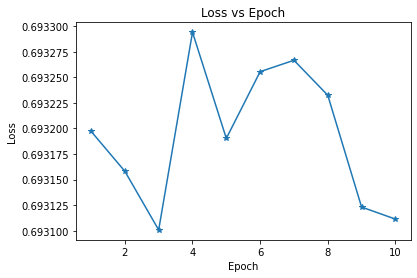

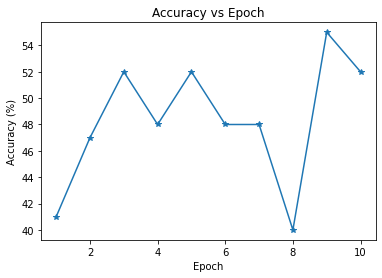

In [ ]:
plt.plot(range(1,11),df_train_error,'*-')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print()

plt.plot(range(1,11),df_train_acc,'*-')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
def deepfake_final(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 10
  epoch_loss = 0
  epoch_acc = 0
  for images, labels in test_loader_df:
    # images = torch.permute(images, (0, 2, 3, 1))1
    # print(images.shape)

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    epoch_loss += loss.item()
    epoch_acc += accuracy(outputs,labels)

  print("Testing loss =", epoch_loss/(len(test_loader_df)))
  print("Testing accuracy =", epoch_acc/(len(test_loader_df)))
  print()

  return epoch_loss/(len(test_loader_df)), epoch_acc/(len(test_loader_df))


In [ ]:
test_df_loss , test_df_acc = deepfake_final(deepfake_detect)

Testing loss = 0.6932058602571487
Testing accuracy = 48.0

